In [1]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [2]:
! kaggle datasets download -d virajbagal/roco-dataset


Dataset URL: https://www.kaggle.com/datasets/virajbagal/roco-dataset
License(s): CC0-1.0
100% 6.17G/6.19G [00:33<00:00, 248MB/s]
100% 6.19G/6.19G [00:33<00:00, 197MB/s]


In [3]:
!unzip roco-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: all_data/validation/radiology/images/PMC3870636_CRIM.OTOLARYNGOLOGY2013-650428.002.jpg  
  inflating: all_data/validation/radiology/images/PMC3870648_CRIM.DENTISTRY2013-378062.012.jpg  
  inflating: all_data/validation/radiology/images/PMC3871037_enm-28-326-g001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872022_CRIM.MEDICINE2013-653925.001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872161_CRIM.SURGERY2013-209494.001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872390_CRIM.OBGYN2013-906351.001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872571_OJO-6-193-g005.jpg  
  inflating: all_data/validation/radiology/images/PMC3872571_OJO-6-193-g007.jpg  
  inflating: all_data/validation/radiology/images/PMC3872649_SNI-4-150-g001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872649_SNI-4-150-g014.jpg  
  inflating: all_data/validation/radiology/images/PMC38

In [4]:
BASE_DIR = '/content/all_data/train/radiology'
WORKING_DIR = '/content/'

In [5]:
import csv

# Path to the CSV file
input_csv_path = '/content/all_data/train/radiology/traindata.csv'
# Path to the output text file
output_txt_path = '/content/all_data/train/radiology/output.txt'

# Open the CSV file and the output text file
with open(input_csv_path, 'r') as csv_file, open(output_txt_path, 'w') as txt_file:
    csv_reader = csv.DictReader(csv_file)  # Read the CSV file as a dictionary

    for row in csv_reader:
        name = row['name']  # Get the 'name' column
        caption = row['caption']  # Get the 'caption' column

        # Write to the text file in the format: name,caption
        txt_file.write(f"{name},{caption}")

print(f"Name and caption have been written to {output_txt_path}.")


Name and caption have been written to /content/all_data/train/radiology/output.txt.


In [6]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'images')

count=0
for img_name in tqdm(os.listdir(directory)):
    if count==50:
      break
    count+=1
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    print(feature.shape)

  0%|          | 0/65420 [00:00<?, ?it/s]

(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)


In [8]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR, 'output.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    if image_id not in features.keys():
      continue
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/65450 [00:00<?, ?it/s]

In [12]:
mapping

{'PMC3639690_CRIM': [' Chest X-ray 5\u2009h after surgery demonstrates complete opacification of the left hemothorax with shift of the mediastinum to the right.',
  ' An AP chest X-ray in the trauma bay showed no obvious pneumothorax  hemothorax  or bullet fragment.'],
 'PMC3088390_wjem12_1p0121f1': [' Chest radiograph demonstrating the presence of bowel loops (black arrow) above the liver with apparent elevation of the right hemidiaphragm. These findings were interpreted as bowel interposition by a staff radiologist.'],
 'PMC3570173_ETM-05-03-0865-g02': [' Tricuspid regurgitation caused by irregular adhesion of the right ventricular septal defect. AO  aorta; LA  left atrium; RA  right atrium; RV  right ventricle; RVOT  right ventricular outflow tract. Arrow indicates shunt flows.'],
 'PMC3854602_10-1055-s-0033-1354253-i1300029-5': ['  Dysphagia following collapse of long-segment construct.'],
 'PMC4684844_CRINM2015-103624': [' Sagittal view of T2 diffusion MRI lumbar spine showing het

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
# before preprocess of text
mapping['PMC3639690_CRIM']

[' Chest X-ray 5\u2009h after surgery demonstrates complete opacification of the left hemothorax with shift of the mediastinum to the right.',
 ' An AP chest X-ray in the trauma bay showed no obvious pneumothorax  hemothorax  or bullet fragment.']

In [16]:
# preprocess the text
clean(mapping)

In [17]:
# before preprocess of text
mapping['PMC3639690_CRIM']

['startseq chest x-ray after surgery demonstrates complete opacification of the left hemothorax with shift of the mediastinum to the right. endseq',
 'startseq an ap chest x-ray in the trauma bay showed no obvious pneumothorax hemothorax or bullet fragment. endseq']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

57

In [20]:
all_captions[:10]

['startseq chest x-ray after surgery demonstrates complete opacification of the left hemothorax with shift of the mediastinum to the right. endseq',
 'startseq an ap chest x-ray in the trauma bay showed no obvious pneumothorax hemothorax or bullet fragment. endseq',
 'startseq chest radiograph demonstrating the presence of bowel loops (black arrow) above the liver with apparent elevation of the right hemidiaphragm. these findings were interpreted as bowel interposition by staff radiologist. endseq',
 'startseq tricuspid regurgitation caused by irregular adhesion of the right ventricular septal defect. ao aorta; la left atrium; ra right atrium; rv right ventricle; rvot right ventricular outflow tract. arrow indicates shunt flows. endseq',
 'startseq dysphagia following collapse of long-segment construct. endseq',
 'startseq sagittal view of t2 diffusion mri lumbar spine showing heterogeneous lesions (arrow) involving the paraspinal muscles with ring enhancement consistent with abscess. 

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
vocab_size

536

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

60

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

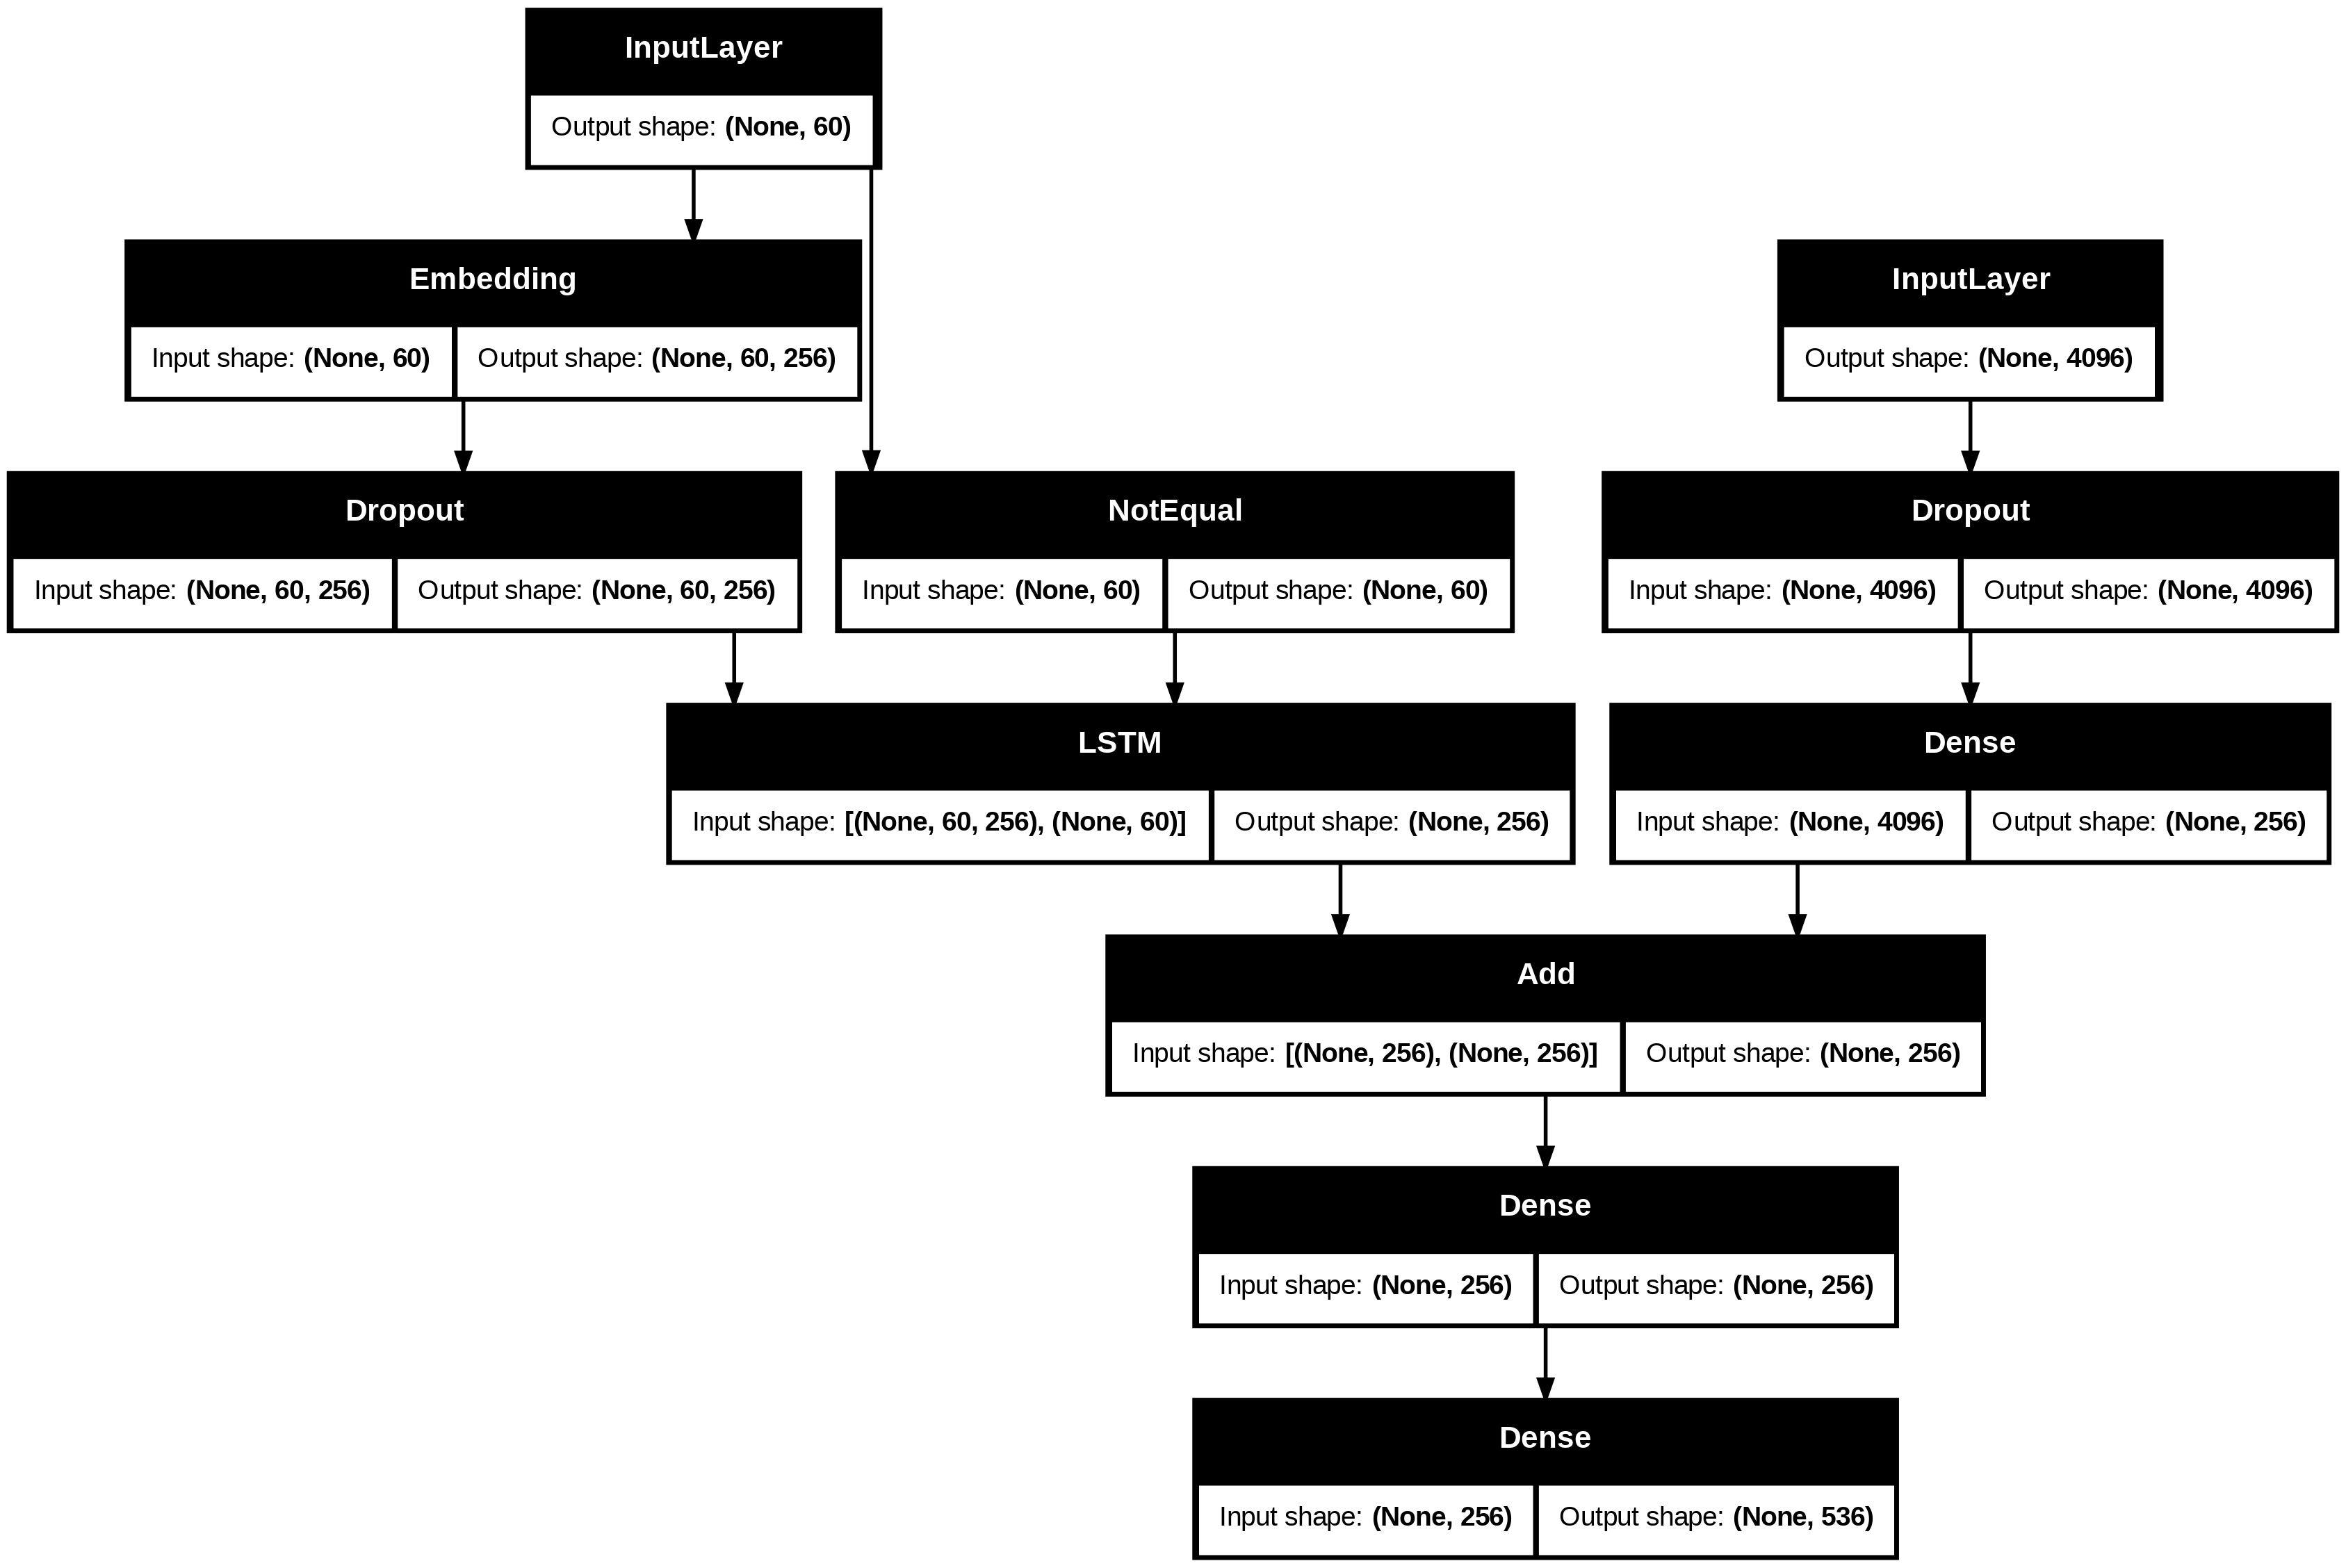

In [25]:
# encoder model
# image feature layers

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [26]:
from sklearn.model_selection import train_test_split

dataset_keys = list(mapping.keys())  # Keys for all images in the dataset

# Split the dataset into training, validation, and testing sets
train_keys, val_keys = train_test_split(dataset_keys, test_size=0.2, random_state=42)


In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize storage
    X1, X2, y = [], [], []
    n = 0

    while True:  # Infinite generator
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Collect inputs and outputs
                    X1.append(features[key][0])  # Features
                    X2.append(in_seq)  # Input sequence
                    y.append(out_seq)  # Output sequence

            # Yield batch when size matches batch_size
            n += 1
            if n == batch_size:
                if len(X1) == 0:  # Skip empty batches
                    continue
                # Convert to TensorFlow tensors
                X1_tensor = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)
                X2_tensor = tf.convert_to_tensor(np.array(X2), dtype=tf.float32)
                y_tensor = tf.convert_to_tensor(np.array(y), dtype=tf.float32)

                yield (X1_tensor, X2_tensor), y_tensor

                # Reset storage
                X1, X2, y = [], [], []
                n = 0


output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # Features
        tf.TensorSpec(shape=(None, max_length), dtype=tf.float32),  # Input sequences
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32),  # Output sequences
)
batch_size=32
def safe_data_generator():
    try:
        yield from data_generator(train_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    except Exception as e:
        print(f"Error in generator: {e}")
# Create a dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    safe_data_generator,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32),
    )
)



steps_per_epoch = len(train_keys) // 32
model.fit(train_dataset, epochs=200, steps_per_epoch=steps_per_epoch, verbose=1)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6973
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6575
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6288
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6766
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6677
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6281
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6181
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6112
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6581
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6143
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5901
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5653
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5651
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5805
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5709
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 

In [29]:
# save the model
model.save(WORKING_DIR+'/best_model.keras')

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import keras

def load_trained_model(model_path):
    """Load a pre-trained model from an .h5 file."""
    model = load_model(model_path,safe_mode=True)
    return model

In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    model=keras.models.load_model("/content/best_model.keras")
    # add start tag for generation process
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(train_keys):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/40 [00:00<?, ?it/s]

BLEU-1: 0.845956
BLEU-2: 0.785500


In [34]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [43]:
import os

# Define the directory path
directory_path = '/content/all_data/train/radiology/images/'

# Check if the directory exists
if os.path.exists(directory_path):
    # List all files and directories
    all_files = os.listdir(directory_path)

    # Print the first 5 items
    print("First 5 files or directories:")
    for item in all_files[:5]:  # Get the first 5
        print(item)
else:
    print(f"Directory not found: {directory_path}")


First 5 files or directories:
PMC3353704_DRJ-9-233-g004.jpg
PMC5006345_LI-33-562-g002.jpg
PMC3854574_10-1055-s-0033-1337123-i1200056-3.jpg
PMC3639690_CRIM.EM2013-198617.003.jpg
PMC5603107_CRIM2017-3531823.001.jpg


In [41]:
features

{'PMC3353704_DRJ-9-233-g004': array([[0.        , 0.        , 0.        , ..., 0.66731995, 1.7312522 ,
         1.2061213 ]], dtype=float32),
 'PMC5006345_LI-33-562-g002': array([[2.4019055 , 0.        , 2.0362191 , ..., 0.82065284, 0.        ,
         0.64393264]], dtype=float32),
 'PMC3854574_10-1055-s-0033-1337123-i1200056-3': array([[0.        , 2.45949   , 0.        , ..., 0.29634547, 0.        ,
         1.9653132 ]], dtype=float32),
 'PMC3639690_CRIM': array([[0.        , 0.16237533, 0.97069913, ..., 2.4602447 , 0.        ,
         0.        ]], dtype=float32),
 'PMC5603107_CRIM2017-3531823': array([[0.        , 0.        , 0.47256634, ..., 3.0319998 , 0.        ,
         3.256198  ]], dtype=float32),
 'PMC4873554_JCB-8-27385-g002': array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         3.5006123]], dtype=float32),
 'PMC1828369_ci07000707': array([[0.        , 0.        , 0.26026082, ..., 1.192493  , 0.        ,
         3.2490861 ]], dtype=float32),
 'P

---------------------Actual---------------------
startseq ct taken after recurrence clearly demonstrates the complete loss of architecture of the left maxilla endseq
--------------------Predicted--------------------
startseq ct taken after recurrence clearly demonstrates the complete loss of architecture of the left maxilla endseq


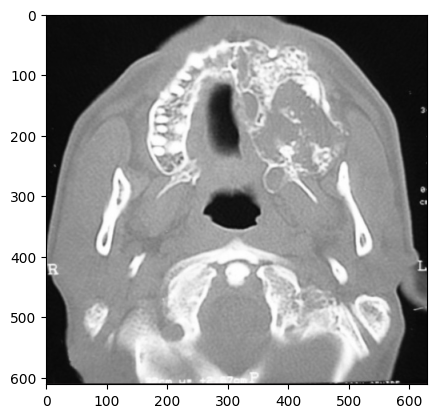

In [44]:
generate_caption("PMC3353704_DRJ-9-233-g004.jpg")

---------------------Actual---------------------
startseq chest x-ray after surgery demonstrates complete opacification of the left hemothorax with shift of the mediastinum to the right. endseq
startseq an ap chest x-ray in the trauma bay showed no obvious pneumothorax hemothorax or bullet fragment. endseq
--------------------Predicted--------------------
startseq an ap chest x ray in the trauma bay showed no obvious pneumothorax hemothorax or bullet fragment endseq


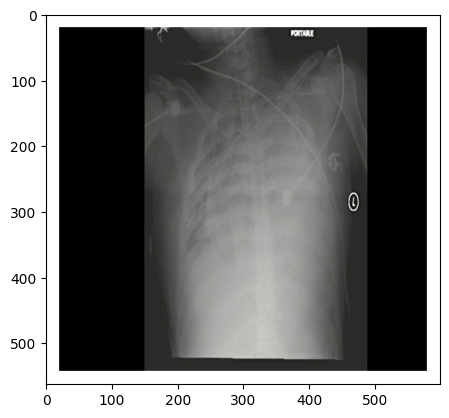

In [45]:
generate_caption("PMC3639690_CRIM.EM2013-198617.003.jpg")

---------------------Actual---------------------
startseq ct of chest with contrast showing 10 13 cm soft tissue mass in the left anterior lower hemithorax from the left anterior 6th rib to the eo muscle and left pericardium inseparable from lv myocardium. endseq
startseq ct of abdomen with contrast showing unremarkable liver spleen pancreas and adrenal glands. endseq
--------------------Predicted--------------------
startseq ct of abdomen with contrast showing unremarkable liver spleen pancreas and adrenal glands endseq


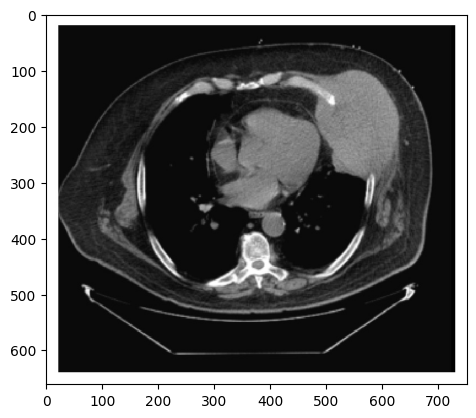

In [47]:
generate_caption("PMC5603107_CRIM2017-3531823.001.jpg")

---------------------Actual---------------------
startseq sagittal sections of the magnetic resonance imaging (t1-weighted) showing extension of the abscess from c0–c3. endseq
--------------------Predicted--------------------
startseq sagittal sections of the magnetic resonance imaging t1 weighted showing extension of the abscess from c0–c3 endseq


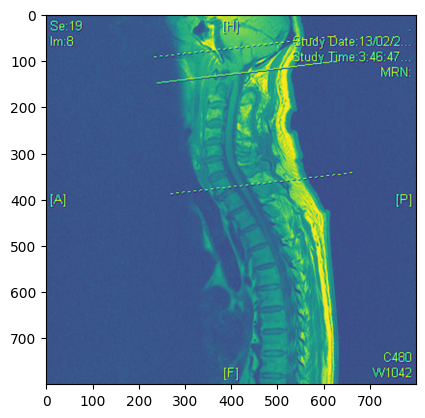

In [49]:
generate_caption("PMC3854574_10-1055-s-0033-1337123-i1200056-3.jpg")